In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
df = pd.read_csv('/content/final_data.csv', encoding='euc-kr')
df.head()


,Country,Year,Population Ages 0-14 (%),Usage Rate,Urban Population (%),v2x_libdem,GDP,Export,Import,ODA 수여액,인터넷(%),입학률(%),FDI_Inward\n,FDI_outward
0,Afghanistan,2010,48.467330,35.47747099,23.737,0.196,1.585667e+10,68222180.0,106278.0,6.235320e+09,4,50.41368866,54.0,-1.0
1,Afghanistan,2011,48.039798,37.16457222,23.948,0.199,1.780510e+10,117138.0,117138.0,6.745740e+09,5,52.19842911,58.0,1.0
2,Afghanistan,2012,47.605305,38.86030503,24.160,0.200,1.990733e+10,48147.0,48147.0,6.666770e+09,5.45,54.20639038,41.0,-9.0
3,Afghanistan,2013,47.161386,40.56485238,24.373,0.202,2.014642e+10,142185.0,142185.0,5.152540e+09,5.9,54.75421906,48.0,1.0
4,Afghanistan,2014,46.713066,42.27840265,24.587,0.201,2.049713e+10,28259.0,28259.0,4.942970e+09,7,54.23548126,43.0,0.0


In [3]:
df['Country'].value_counts()

,count
Country,
Afghanistan,13
Albania,13
Algeria,13
Angola,13
Argentina,13
...,...
Uruguay,13
Uzbekistan,13
Vanuatu,13


#데이터 전처리

In [4]:
df = df[df['Country']!='South Sudan']
df.loc[df['Country']=='West Bank and Gaza']= df[df['Country']=='West Bank and Gaza'].drop_duplicates(subset=['Country','Year'],keep='first')
#------------ Country 제외 숫자형으로 데이터 타입 변경 & Year 열 datetime으로 ------------------------------------------
exclude_cols = ['Country']
cols_to_convert = df.columns.difference(exclude_cols)
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year
#------------열 이름 변경 -----------------------------------------------------------------------
df = df.rename(columns={'FDI_Inward\n':'FDI_Inward','Usage Rate':'Safe Sanitation(%)'})


#------------국가 제거 --------------------------------------------------------------------------
remove_countries = [
    'Bosnia and Herzegovina',
    "Cote d'Ivoire",
    'Dominican Republic',
    'Solomon Islands',
    'Sudan',
    'Libya',
    'Kosovo'
]
df = df[~df['Country'].isin(remove_countries)]

#----------- Safe Sanitation (%)  -------------------------------------------------------------------------
# 순방향 보정된 값들을 지정해 주기
corrections = {
    'Argentina': {2017: 95.24, 2018: 95.66, 2019: 96.08, 2020: 96.49, 2021: 96.91, 2022: 97.33},
    'Mauritius': {2018: 95.63, 2019: 95.81, 2020: 95.98, 2021: 96.17, 2022: 96.33},
    'Croatia': {2021: 96.17, 2022: 96.17},
    'Bosnia and Herzegovina': {2019: 95.40, 2020: 95.43, 2021: 95.45, 2022: 95.48},
    'Nicaragua': {2021: 73.07, 2022: 73.12},
    'Solomon Islands': {2022: 35.28},
    'Azerbaijan': {2020: 96.12}
}

# 데이터를 순방향 보정된 값들로 대체
for country, year_data in corrections.items():
    for year, value in year_data.items():
        df.loc[(df['Country'] == country) & (df['Year'] == year), 'Safe Sanitation(%)'] = value

# Equatorial Guinea의 결측값 처리: 선형 보간법 적용
df.loc[df['Country'] == 'Equatorial Guinea', 'Safe Sanitation(%)'] = 66.31




#------------ FDI Inward ------------------------------------------------------------------------
# Guinea 2011 → 중앙값 187.5
df.loc[(df['Country'] == 'Guinea') & (df['Year'] == 2011), 'FDI_Inward'] = 187.5

# Afghanistan 2022 → 중앙값 50.0
df.loc[(df['Country'] == 'Afghanistan') & (df['Year'] == 2022), 'FDI_Inward'] = 50.0


#------------ 인터넷(%) -------------------------------------------------------------------------
# 역방향 보정: Sri Lanka 2010-2013
df.loc[(df['Country'] == 'Sri Lanka') & (df['Year'] == 2013), '인터넷(%)'] = 5.775
df.loc[(df['Country'] == 'Sri Lanka') & (df['Year'] == 2012), '인터넷(%)'] = 1.05
df.loc[(df['Country'] == 'Sri Lanka') & (df['Year'] == 2011), '인터넷(%)'] = 0.0
df.loc[(df['Country'] == 'Sri Lanka') & (df['Year'] == 2010), '인터넷(%)'] = 0.0

# 순방향 보정: Uganda 2017-2019
df.loc[(df['Country'] == 'Uganda') & (df['Year'] == 2017), '인터넷(%)'] = 6.275
df.loc[(df['Country'] == 'Uganda') & (df['Year'] == 2018), '인터넷(%)'] = 6.65
df.loc[(df['Country'] == 'Uganda') & (df['Year'] == 2019), '인터넷(%)'] = 7.025

# 순방향 보정: Kenya 2020-2022
df.loc[(df['Country'] == 'Kenya') & (df['Year'] == 2020), '인터넷(%)'] = 25.9
df.loc[(df['Country'] == 'Kenya') & (df['Year'] == 2021), '인터넷(%)'] = 29.1
df.loc[(df['Country'] == 'Kenya') & (df['Year'] == 2022), '인터넷(%)'] = 32.3

# 순방향 보정: Tajikistan 2018-2019
df.loc[(df['Country'] == 'Tajikistan') & (df['Year'] == 2018), '인터넷(%)'] = 23.83
df.loc[(df['Country'] == 'Tajikistan') & (df['Year'] == 2019), '인터넷(%)'] = 25.66

# 평균값으로 대체
df.loc[(df['Country'] == 'Cambodia') & (df['Year'] == 2018), '인터넷(%)'] = 42.6
df.loc[(df['Country'] == 'India') & (df['Year'] == 2021), '인터넷(%)'] = 49.6
df.loc[(df['Country'] == 'Equatorial Guinea') & (df['Year'] == 2018), '인터넷(%)'] = 37.6
df.loc[(df['Country'] == 'Papua New Guinea') & (df['Year'] == 2018), '인터넷(%)'] = 15.6
df.loc[(df['Country'] == 'Niger') & (df['Year'] == 2018), '인터넷(%)'] = 13.4


In [5]:
df.columns

Index(['Country', 'Year', 'Population Ages 0-14 (%)', 'Safe Sanitation(%)',
       'Urban Population (%)', 'v2x_libdem', 'GDP', 'Export', 'Import',
       'ODA 수여액', '인터넷(%)', '입학률(%)', 'FDI_Inward', 'FDI_outward'],
      dtype='object')

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


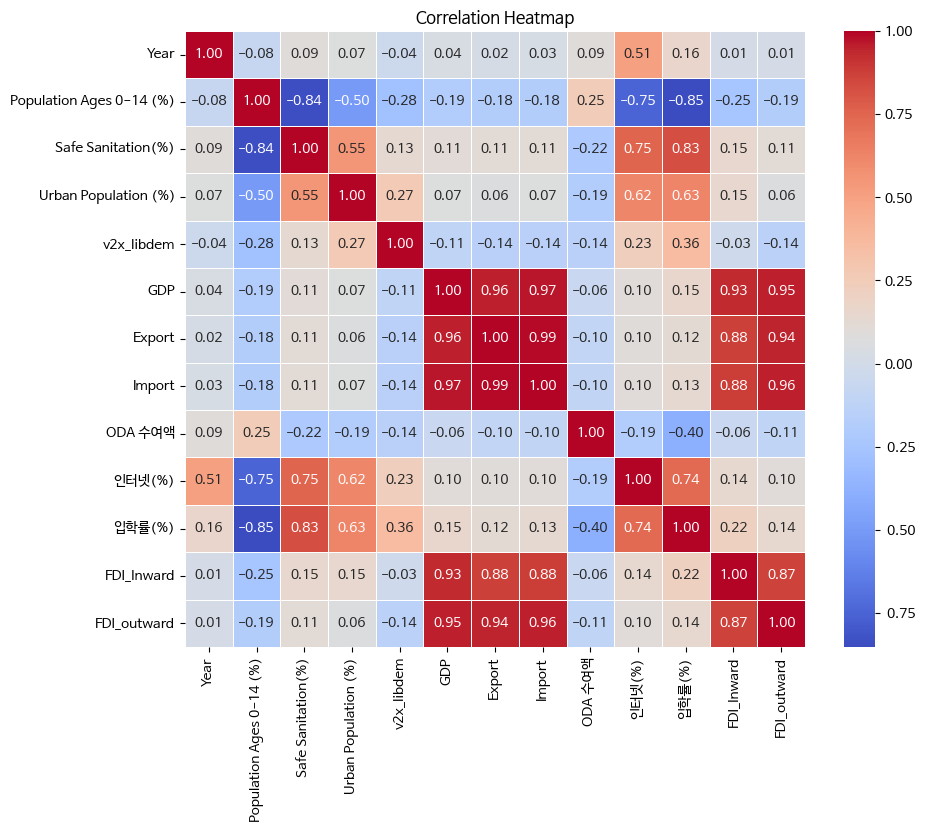

In [6]:
df_without_country = df.drop(columns=['Country'])
corr=df_without_country.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 스케일링

In [8]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df

,Country,Year,Population Ages 0-14 (%),Safe Sanitation(%),Urban Population (%),v2x_libdem,GDP,Export,Import,ODA 수여액,인터넷(%),입학률(%),FDI_Inward,FDI_outward
0,Afghanistan,2010,1.731206,-1.167847,-1.408496,-0.813357,-0.197517,-0.176928,-0.183013,4.415940,-1.384208,-1.021235,-0.291554,-0.169571
1,Afghanistan,2011,1.687018,-1.107774,-1.398307,-0.799250,-0.196085,-0.182925,-0.183012,4.825411,-1.345652,-0.953022,-0.291324,-0.169441
2,Afghanistan,2012,1.642111,-1.047393,-1.388069,-0.794547,-0.194540,-0.182931,-0.183018,4.762059,-1.328302,-0.876277,-0.292301,-0.170091
3,Afghanistan,2013,1.596230,-0.986698,-1.377783,-0.785142,-0.194364,-0.182923,-0.183010,3.547309,-1.310952,-0.855339,-0.291898,-0.169441
4,Afghanistan,2014,1.549894,-0.925683,-1.367449,-0.789845,-0.194106,-0.182933,-0.183020,3.379188,-1.268541,-0.875165,-0.292186,-0.169506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,Zimbabwe,2018,1.157906,-1.136524,-0.999375,-0.742819,-0.184065,-0.182503,-0.182578,0.051239,-0.574537,NaN,-0.251854,-0.167749
1231,Zimbabwe,2019,1.118819,-1.157276,-0.999327,-0.808655,-0.190269,-0.181782,-0.181835,0.090973,-0.512848,NaN,-0.278570,-0.167423
1232,Zimbabwe,2020,1.081770,-1.177999,-0.997782,-0.832167,-0.189423,-0.181933,-0.181991,0.204054,-0.408748,NaN,-0.283510,-0.167358
1233,Zimbabwe,2021,1.049536,-1.198737,-0.994836,-0.850977,-0.189149,-0.182087,-0.182150,0.204648,-0.108013,NaN,-0.280293,-0.167423
